In [41]:
import numpy as np
import wave
import matplotlib.pyplot as plt
import math 
import scipy.special as sp
import librosa as lb
import librosa.display as lbd
from numpy.random import randint


# Load Audio File for Testing

C:\Users\jewel\AppData\Local\Temp\ipykernel_9692\2358501384.py:3: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  lbd.waveshow(x1,fs)


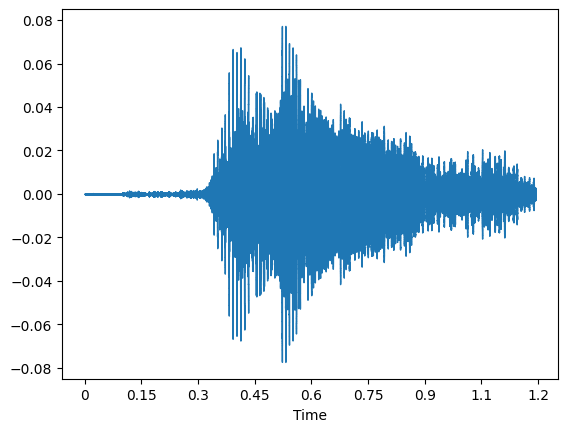

In [42]:
x1, fs = lb.load('hello.wav')
x1 = x1[5000:len(x1)-1]
lbd.waveshow(x1,fs)

# Functions to Add Noise to Audio Signal

In [43]:
def addWhiteNoise(data, SNRdB):
    
    snr = 10 ** (SNRdB / 10)
    signalPower = np.sum(abs(data) ** 2) / len(data)
    noisePower = signalPower / snr
    noise = np.sqrt(noisePower / 2) * np.random.random(data.shape)
    noisySignal = data + noise 

    return noisySignal

def addNoise(data,SNRdB,noise_type):

    snr = 10 ** (SNRdB / 10)
    signalPower = np.sum(abs(data) ** 2) / len(data)
    noisePower = signalPower / snr
    path = r"F:\SSP\Project\noises\noises\{}.wav".format(noise_type)

    noise_file,_ = lb.load(path)
    
    index = randint(0,len(noise_file)-len(data))
    noise_file = noise_file[index:index+len(data)]
    # normalise noise_file
    noise_file = noise_file / np.max(np.abs(noise_file))
    noise = np.sqrt(noisePower / 2) * noise_file
    noisySignal = data + noise 

    return noisySignal

C:\Users\jewel\AppData\Local\Temp\ipykernel_9692\3243603001.py:3: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  lbd.waveshow(x,fs)


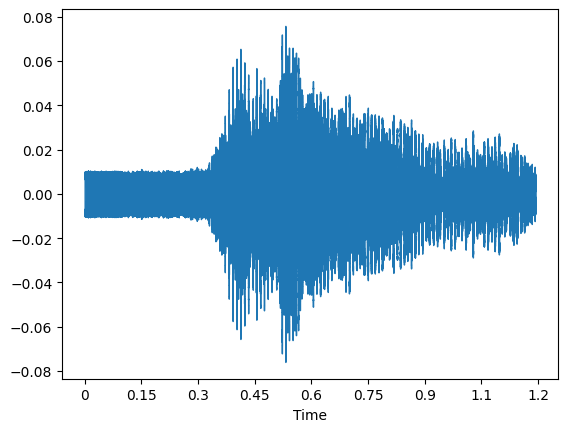

In [44]:
# convert waveform data to an array
x = addWhiteNoise(x1, 0)
lbd.waveshow(x,fs)

# Spectral Subtraction

In [45]:
def spectralSubtraction(x, frame_length, order):

    hop_length = frame_length // 2
    len2 = frame_length - hop_length
    snr_threshold = 2
    G = 0.8
    win = np.hamming(frame_length)
    winGain = len2 / sum(win)

    nFFT = 2 * 2 ** np.log2(frame_length).astype(int)
    noise_mean = np.zeros(nFFT)

    x_FFT = abs(np.fft.fft(x))
    j = 1
    for k in range(8):
        noise_mean = noise_mean + abs(np.fft.fft(win * x[j:j + frame_length], nFFT))
        j = j + frame_length
    noise_est = noise_mean / 8

    k = 1
    x_old = np.zeros(hop_length)
    Nframes = len(x) // len2 - 1
    y = np.zeros(Nframes * len2)

    for n in range(0, Nframes):
        
        # Windowing
        windowed_frame = win * x[k-1:k + frame_length - 1]
        wf_fft = np.fft.fft(windowed_frame, nFFT)
        sig = abs(wf_fft)
        theta = np.angle(wf_fft)
 
        snr_x = 10 * np.log10(np.linalg.norm(sig, 2) ** 2 / np.linalg.norm(noise_est, 2) ** 2)
        
        sub_speech = sig ** order - noise_est ** order
        sub_speech[sub_speech < 0] = 0
            
        if snr_x < snr_threshold:
            noise_temp = G * noise_est ** order + (1 - G) * sig ** order  
            noise_est = noise_temp ** (1 / order) 
        
        x_new_fft = (sub_speech ** (1 / order)) * np.exp(1j * theta)       
        new_x = np.fft.ifft(x_new_fft).real
        
        y[k-1:k + len2 - 1] = x_old + new_x[0:hop_length]
        x_old = new_x[0 + hop_length:frame_length]

        k = k + len2
            
    return y*winGain


# MMSE Estimator

In [46]:
def mmseProcessing(x, frame_length):

    hop_length = frame_length // 2
    len2 = frame_length - hop_length 

    # setting default parameters
    aa = 0.98
    eta = 0.15
    snr_threshold = 3
    mu = 0.98
    c = np.sqrt(np.pi) / 2
    qk = 0.3
    qkr = (1 - qk) / qk
    ksi_min = 10 ** (-30 / 10)

    hamming_window = np.hamming(frame_length)
    hamming_windowGain = len2 / sum(hamming_window)

    nFFT = 2 * 2 ** np.log2(frame_length).astype(int)
    j = 1
    noise_mean = np.zeros(nFFT)
    for k in range(1, 6):
        noise_mean = noise_mean + abs(np.fft.fft(hamming_window * x[j : j + frame_length] , nFFT))
        j = j + frame_length
    noise_est = noise_mean / 5
    noise_est2 = noise_est ** 2

    # initialize variables
    k = 1
    x_old = np.zeros(len2)
    Nframes = len(x) // len2 - 1
    y = np.zeros(Nframes * len2)

    for n in range(0, Nframes):

        windowed_frame = hamming_window * x[k - 1 : k + frame_length - 1]

        # Take fourier transform of frame
        wf_fft = np.fft.fft(windowed_frame , nFFT)
        sig = abs(wf_fft)
        sig_sq = sig ** 2

        theta = np.angle(wf_fft)  

        snr_sig = 10 * np.log10(np.linalg.norm(sig, 2) ** 2 / np.linalg.norm(noise_est, 2) ** 2)

        gammak = np.minimum(sig_sq / noise_est2 , 40) 
        
        if n == 0:
            ksi = aa + (1 - aa) * np.maximum(gammak - 1 , 0)
        else:
            ksi = aa * Xk_prev / noise_est2 + (1 - aa) * np.maximum(gammak - 1 , 0)
            ksi = np.maximum(ksi_min , ksi)  

        if snr_sig < snr_threshold: 
            noise_est2 = mu * noise_est2 + (1 - mu) * sig_sq 
            noise_est = np.sqrt(noise_est2)

        vk = gammak * ksi / (1 + ksi)
        j_0 = sp.iv(0 , vk/2)
        j_1 = sp.iv(1 , vk/2)    
        C = np.exp(-0.5 * vk)
        A = ((c * (vk ** 0.5)) * C) / gammak      
        B = (1 + vk) * j_0 + vk * j_1             
        hw = A * B                              
    
        mmse_speech = hw * sig

        Xk_prev = mmse_speech ** 2  

        x_spec_new = mmse_speech * np.exp(1j * theta)
        new_x = np.fft.ifft(x_spec_new , nFFT).real

        y[k - 1 : k + len2 - 1] = x_old + new_x[0:hop_length]
        x_old = new_x[hop_length:frame_length]

        k = k + len2
        
    return y * hamming_windowGain


# Analysis of Spectral Processing Methods

<Figure size 640x480 with 0 Axes>

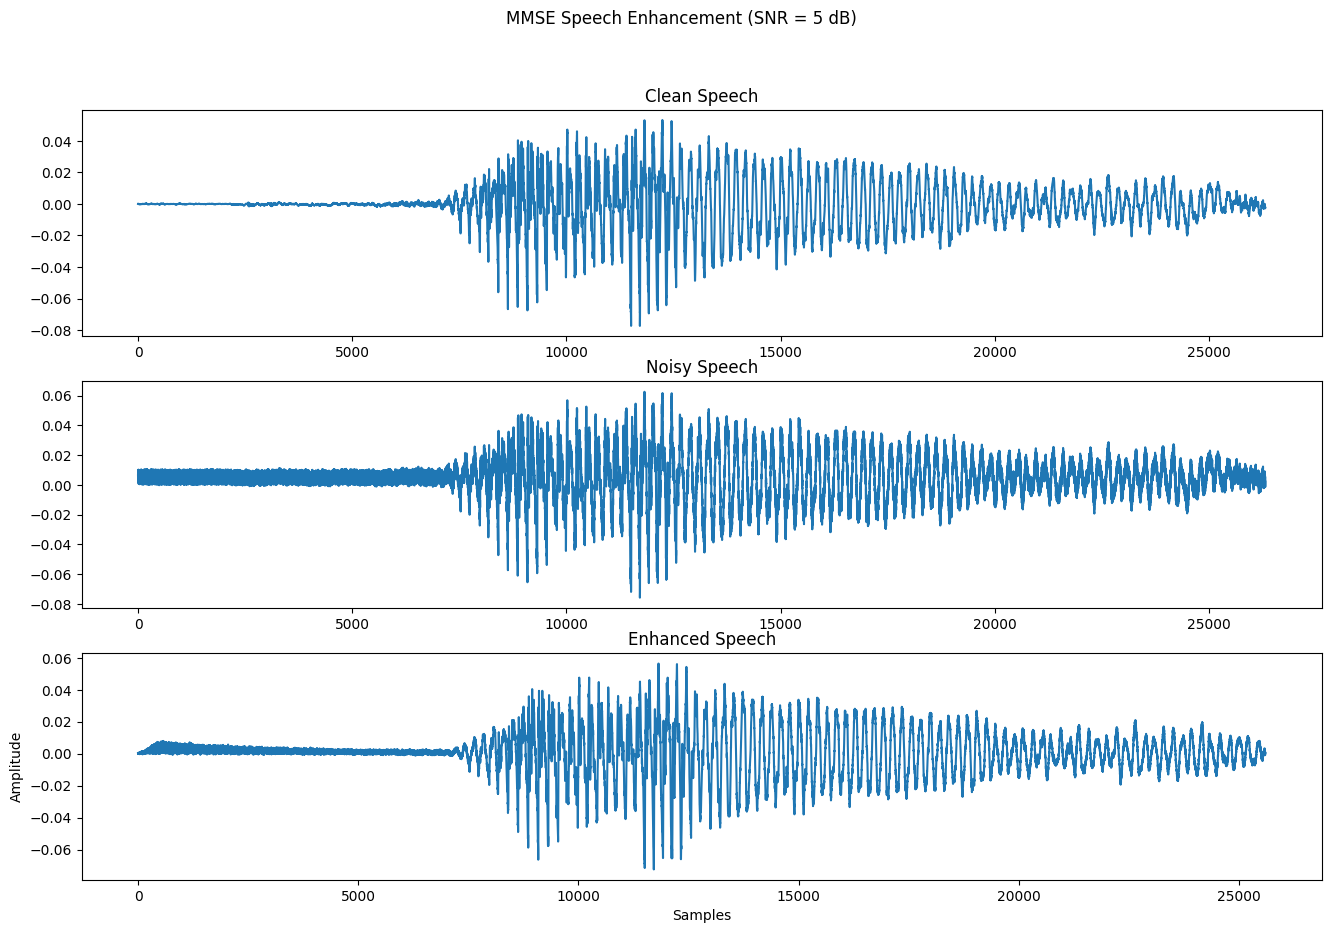

In [47]:
# plot wave
y = mmseProcessing(x, 1024)
plt.figure(1)
plt.figure(figsize=(16, 10))
plt.suptitle('MMSE Speech Enhancement (SNR = 5 dB)')
plt.subplot(311)
plt.plot(x1)
plt.title('Clean Speech')
plt.subplot(312)
plt.plot(x)
plt.title('Noisy Speech')
plt.subplot(313)
plt.plot(y)
plt.title('Enhanced Speech')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.savefig('mmse_.png', bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

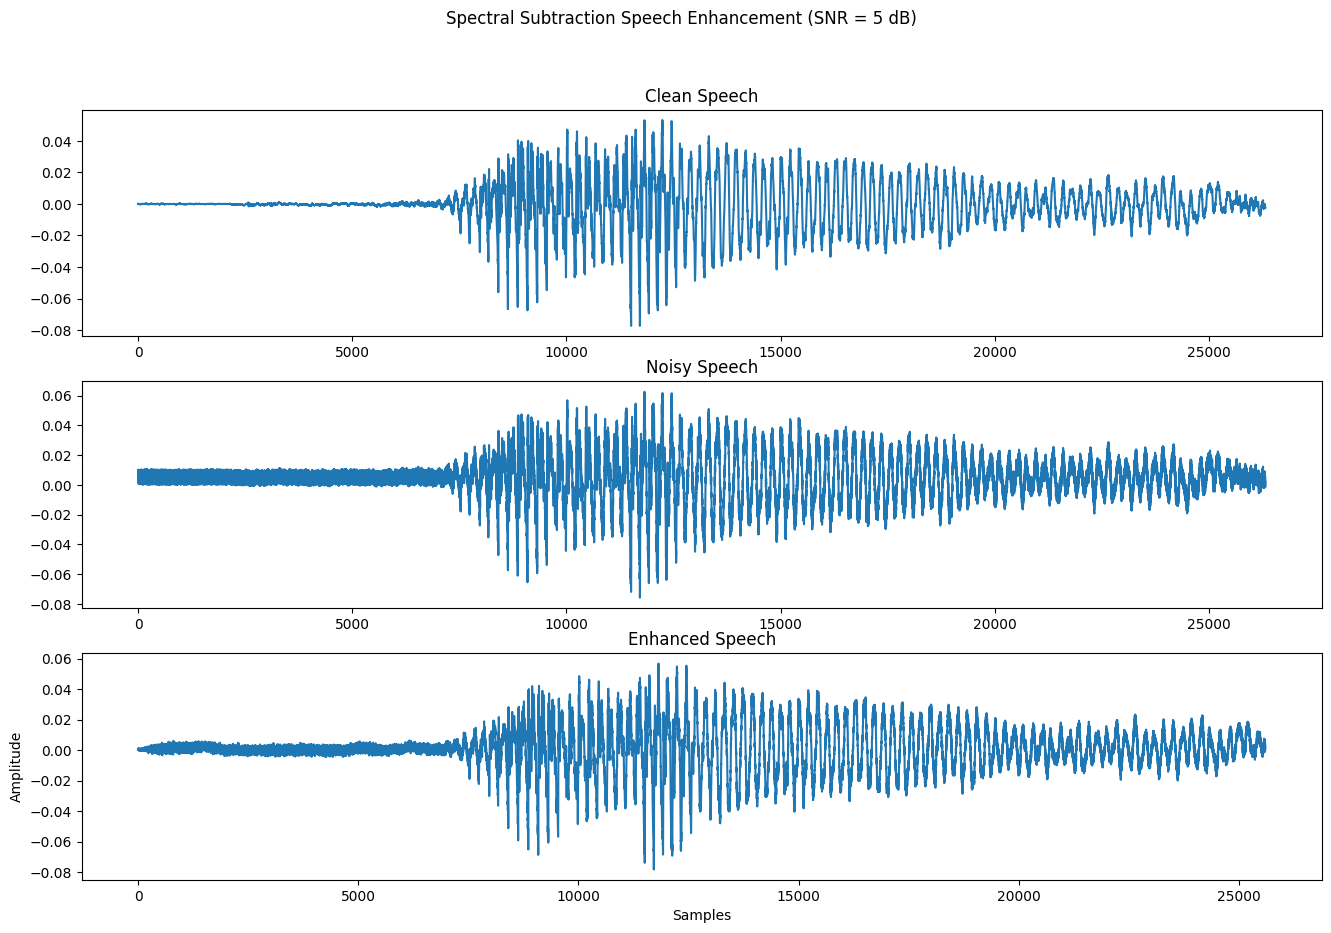

In [48]:
y = spectralSubtraction(x, 1024, 2)
plt.figure(1)
plt.figure(figsize=(16, 10))
plt.suptitle('Spectral Subtraction Speech Enhancement (SNR = 5 dB)')
plt.subplot(311)
plt.plot(x1)
plt.title('Clean Speech')
plt.subplot(312)
plt.plot(x)
plt.title('Noisy Speech')
plt.subplot(313)
plt.plot(y)
plt.title('Enhanced Speech')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.savefig('spec_su_.png', bbox_inches='tight')
plt.show()

In [49]:
def showSpectrogram(x, nFFT, title):
    stft = lb.stft(x, n_fft=nFFT, win_length= nFFT)
    stft_db = lb.amplitude_to_db(np.abs(stft),ref=np.max)
    lbd.specshow(stft_db,x_axis='time',y_axis='linear')
    plt.ylim([0, 4000])
    plt.colorbar(format="%+2.f dB")
    plt.title(title)


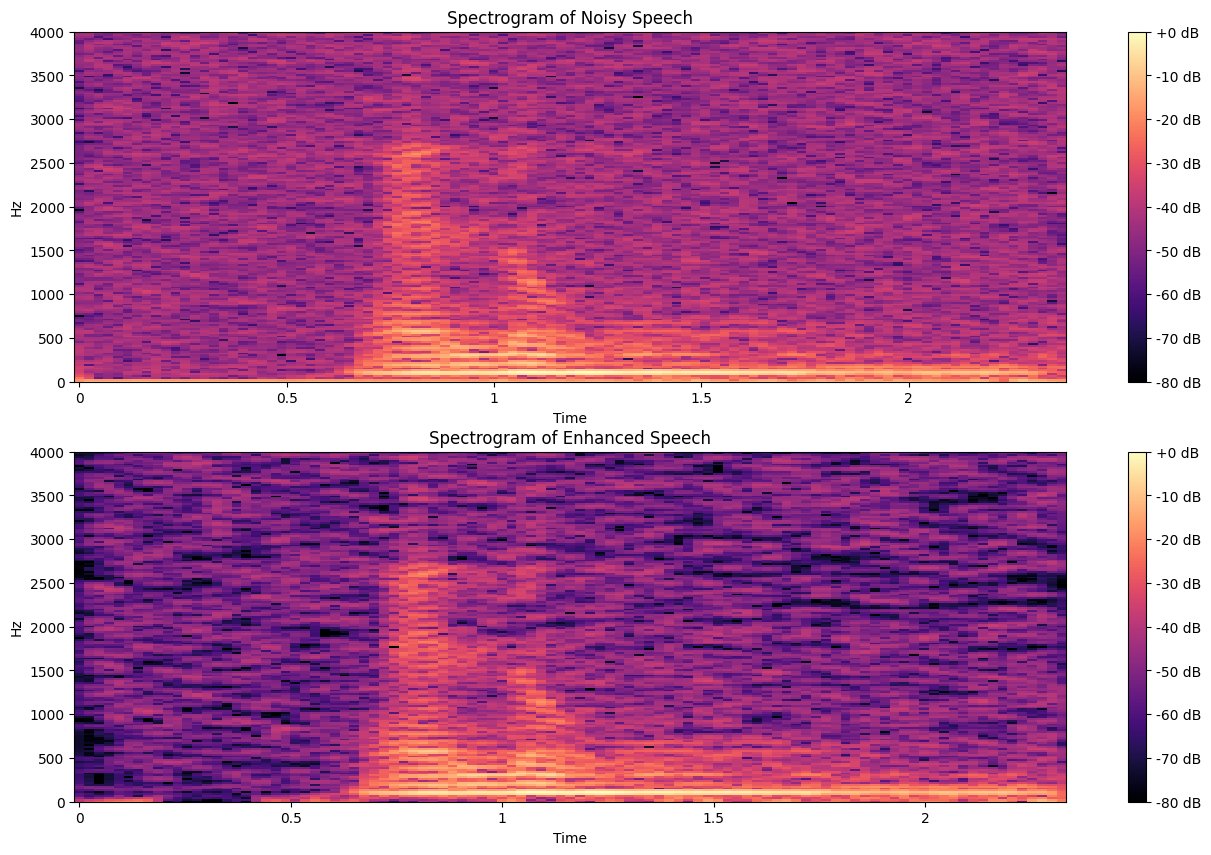

In [50]:
plt.figure(figsize=(16, 10))
plt.subplot(211)
showSpectrogram(x, 1024, 'Spectrogram of Noisy Speech')
plt.subplot(212)
showSpectrogram(y, 1024, 'Spectrogram of Enhanced Speech')
plt.savefig('mmse_spectrogram.png', bbox_inches='tight')

In [86]:
x_white = addNoise(x1, 0, 'white')
x_factory = addNoise(x1, 0, 'factory1')
x_babble = addNoise(x1, 0, 'babble')
x_pink = addNoise(x1, 0, 'pink')

y_white_mmse = mmseProcessing(x_white, 1024)
y_factory_mmse = mmseProcessing(x_factory, 1024)
y_babble_mmse = mmseProcessing(x_babble, 1024)
y_pink_mmse = mmseProcessing(x_pink, 1024)

y_white_sub = spectralSubtraction(x_white, 1024, 2)
y_factory_sub = spectralSubtraction(x_factory, 1024, 2)
y_babble_sub = spectralSubtraction(x_babble, 1024, 2)
y_pink_sub = spectralSubtraction(x_pink, 1024, 2)

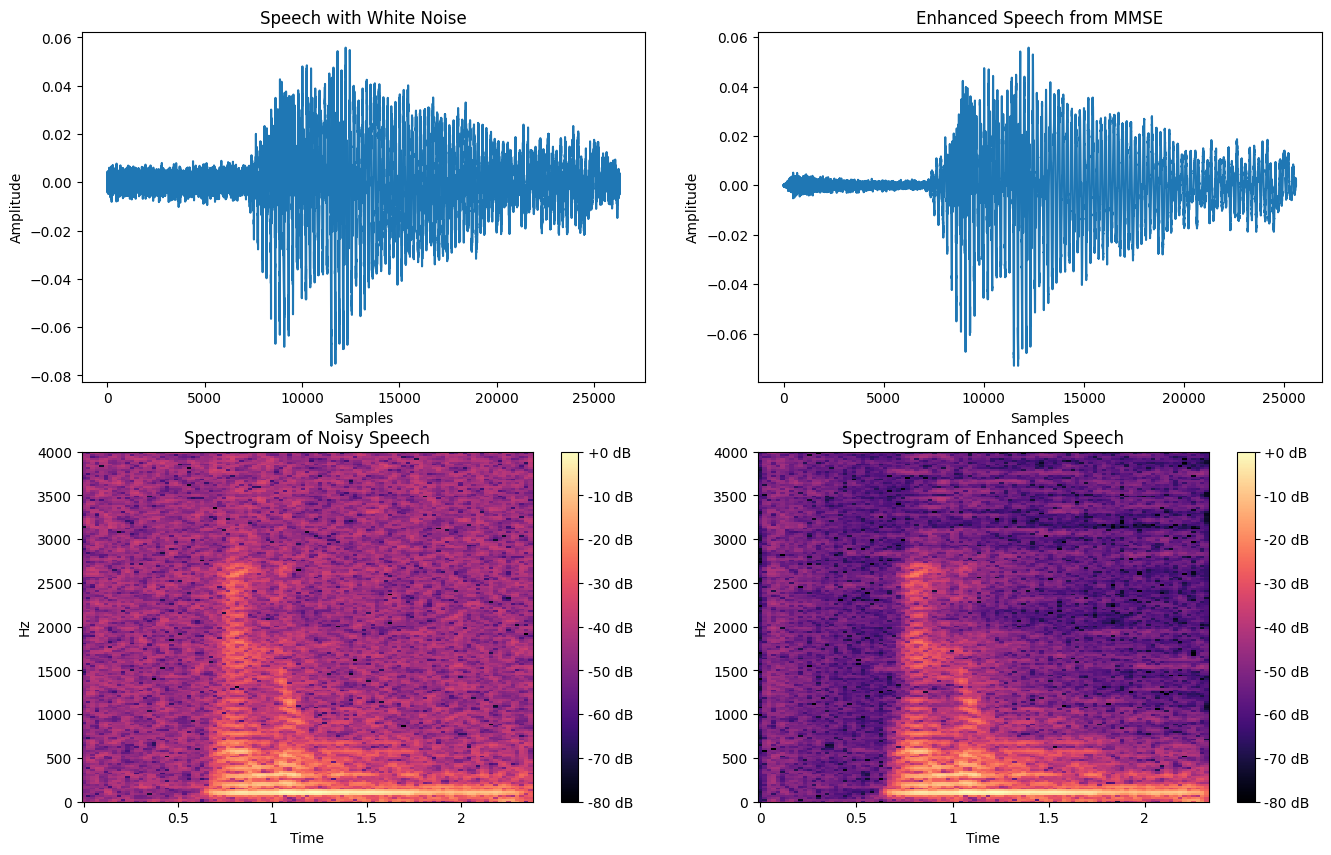

In [87]:
plt.figure(figsize=(16, 10))
plt.subplot(221)
plt.plot(x_white)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Speech with White Noise")
plt.subplot(222)
plt.plot(y_white_mmse)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Enhanced Speech from MMSE")
plt.subplot(223)
showSpectrogram(x_white, 1024, 'Spectrogram of Noisy Speech')
plt.subplot(224)
showSpectrogram(y_white_mmse, 1024, 'Spectrogram of Enhanced Speech')
plt.savefig('mmse_white_comp_0.png', bbox_inches='tight')

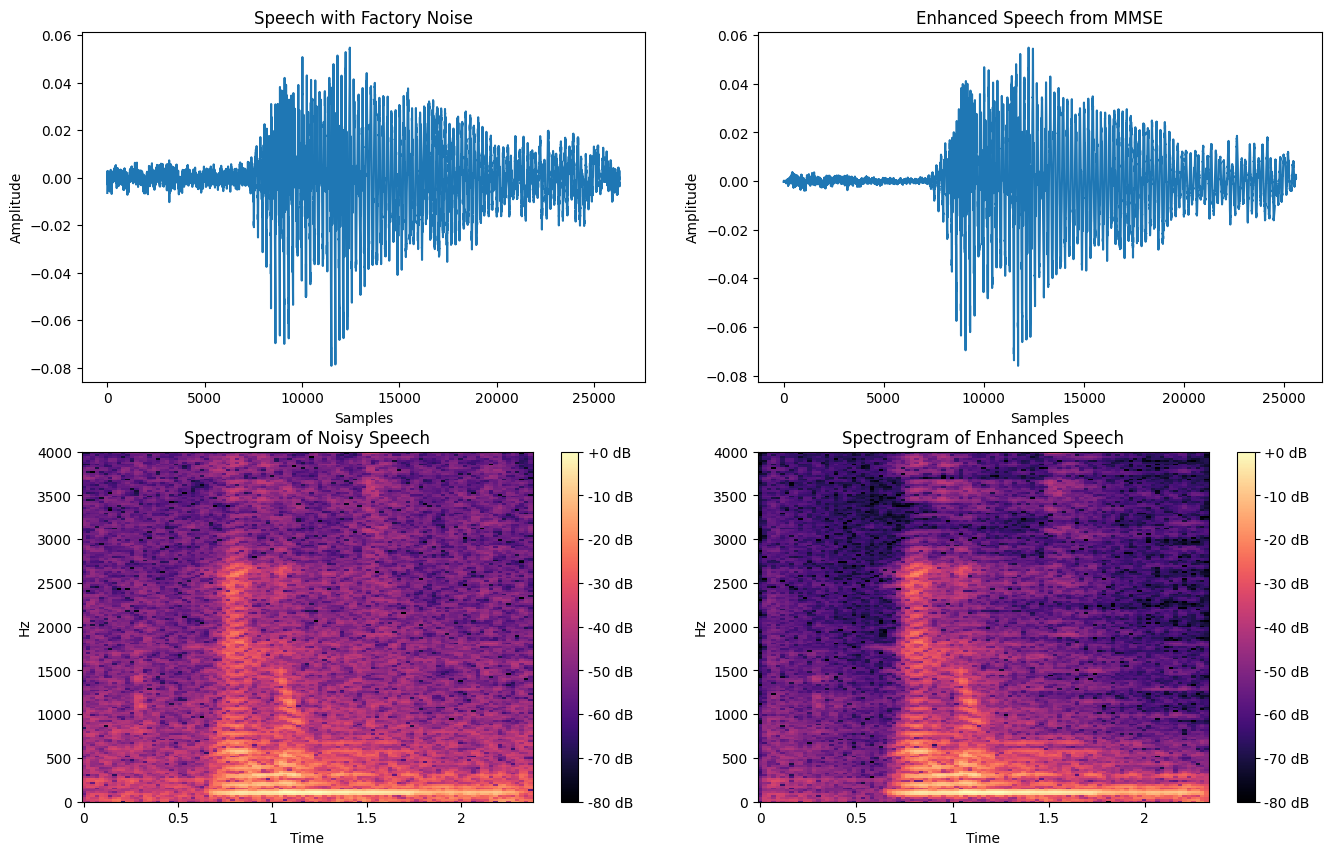

In [88]:
plt.figure(figsize=(16, 10))
plt.subplot(221)
plt.plot(x_factory)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Speech with Factory Noise")
plt.subplot(222)
plt.plot(y_factory_mmse)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Enhanced Speech from MMSE")
plt.subplot(223)
showSpectrogram(x_factory, 1024, 'Spectrogram of Noisy Speech')
plt.subplot(224)
showSpectrogram(y_factory_mmse, 1024, 'Spectrogram of Enhanced Speech')
plt.savefig('mmse_factory_comp_0.png', bbox_inches='tight')

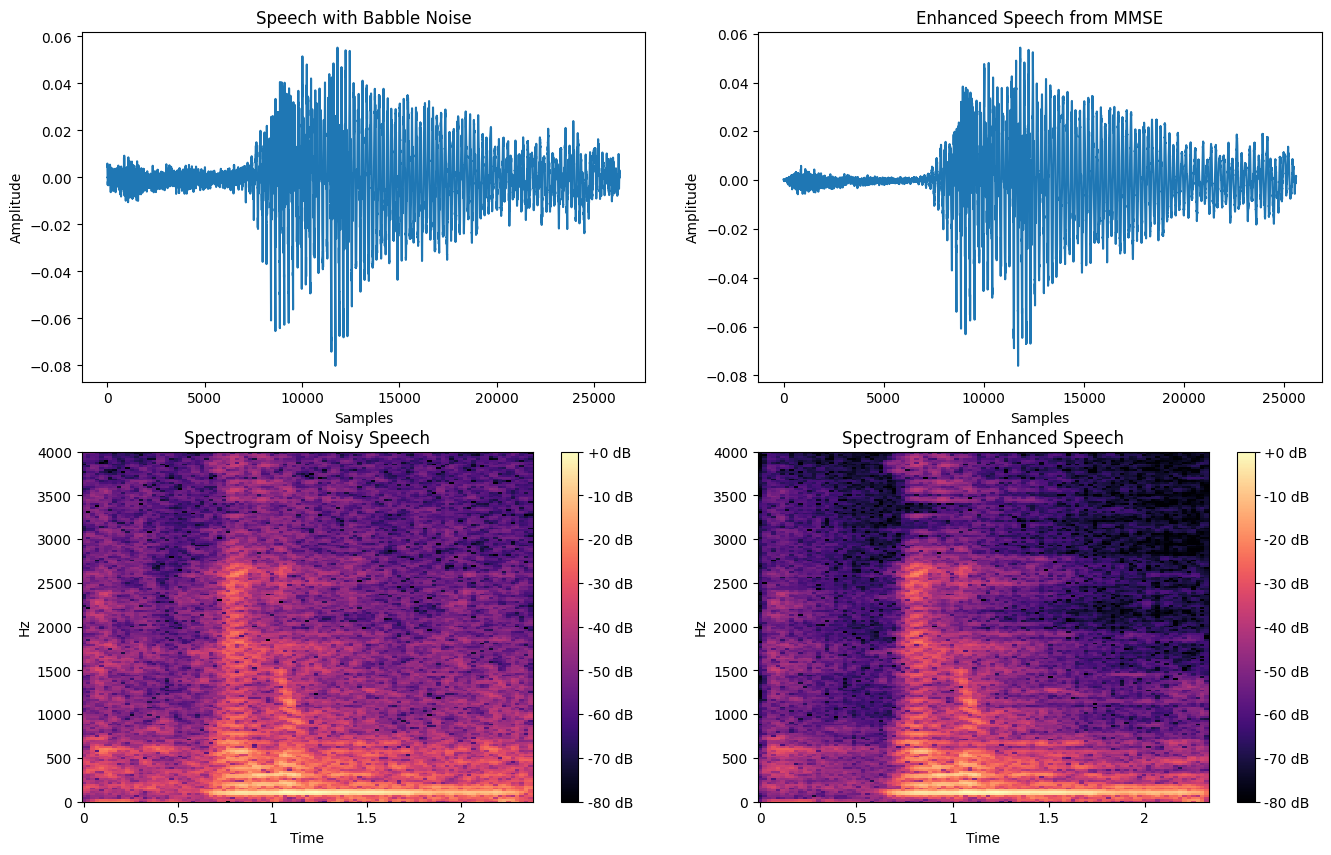

In [89]:
plt.figure(figsize=(16, 10))
plt.subplot(221)
plt.plot(x_babble)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Speech with Babble Noise")
plt.subplot(222)
plt.plot(y_babble_mmse)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Enhanced Speech from MMSE")
plt.subplot(223)
showSpectrogram(x_babble, 1024, 'Spectrogram of Noisy Speech')
plt.subplot(224)
showSpectrogram(y_babble_mmse, 1024, 'Spectrogram of Enhanced Speech')
plt.savefig('mmse_babble_comp_0.png', bbox_inches='tight')

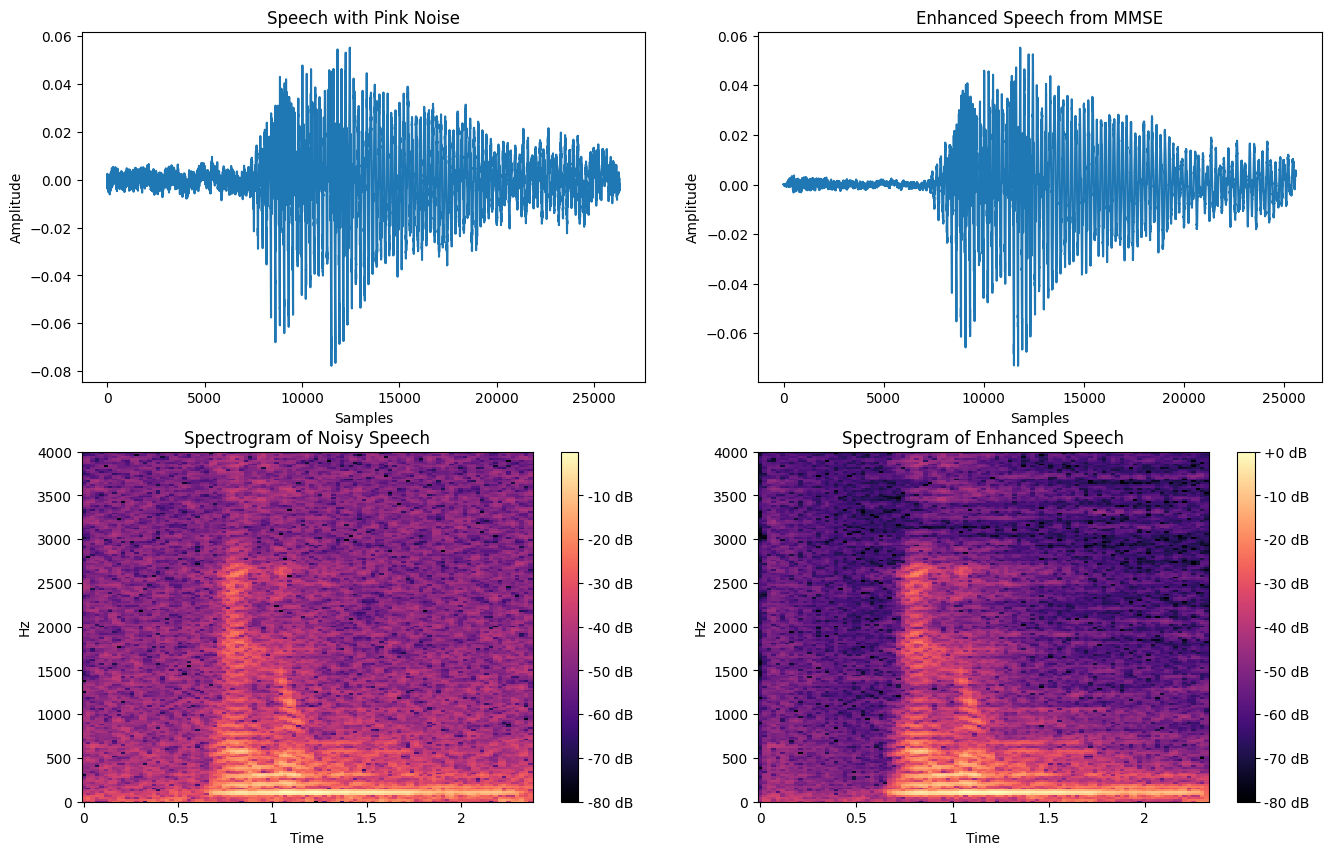

In [90]:
plt.figure(figsize=(16, 10))
plt.subplot(221)
plt.plot(x_pink)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Speech with Pink Noise")
plt.subplot(222)
plt.plot(y_pink_mmse)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Enhanced Speech from MMSE")
plt.subplot(223)
showSpectrogram(x_pink, 1024, 'Spectrogram of Noisy Speech')
plt.subplot(224)
showSpectrogram(y_pink_mmse, 1024, 'Spectrogram of Enhanced Speech')
plt.savefig('mmse_pink_comp_0.png', bbox_inches='tight')

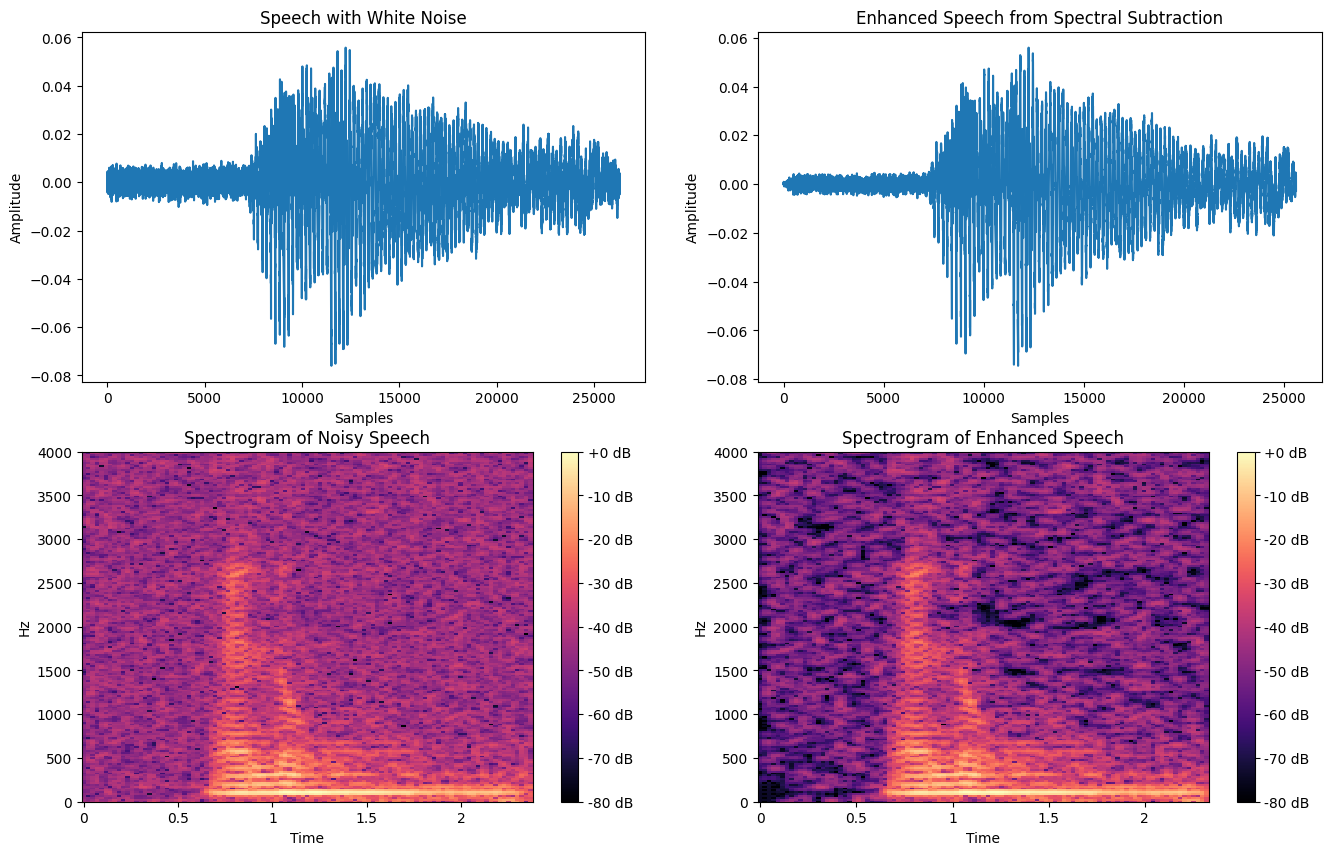

In [91]:
plt.figure(figsize=(16, 10))
plt.subplot(221)
plt.plot(x_white)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Speech with White Noise")
plt.subplot(222)
plt.plot(y_white_sub)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Enhanced Speech from Spectral Subtraction")
plt.subplot(223)
showSpectrogram(x_white, 1024, 'Spectrogram of Noisy Speech')
plt.subplot(224)
showSpectrogram(y_white_sub, 1024, 'Spectrogram of Enhanced Speech')
plt.savefig('sub_white_comp_0.png', bbox_inches='tight')

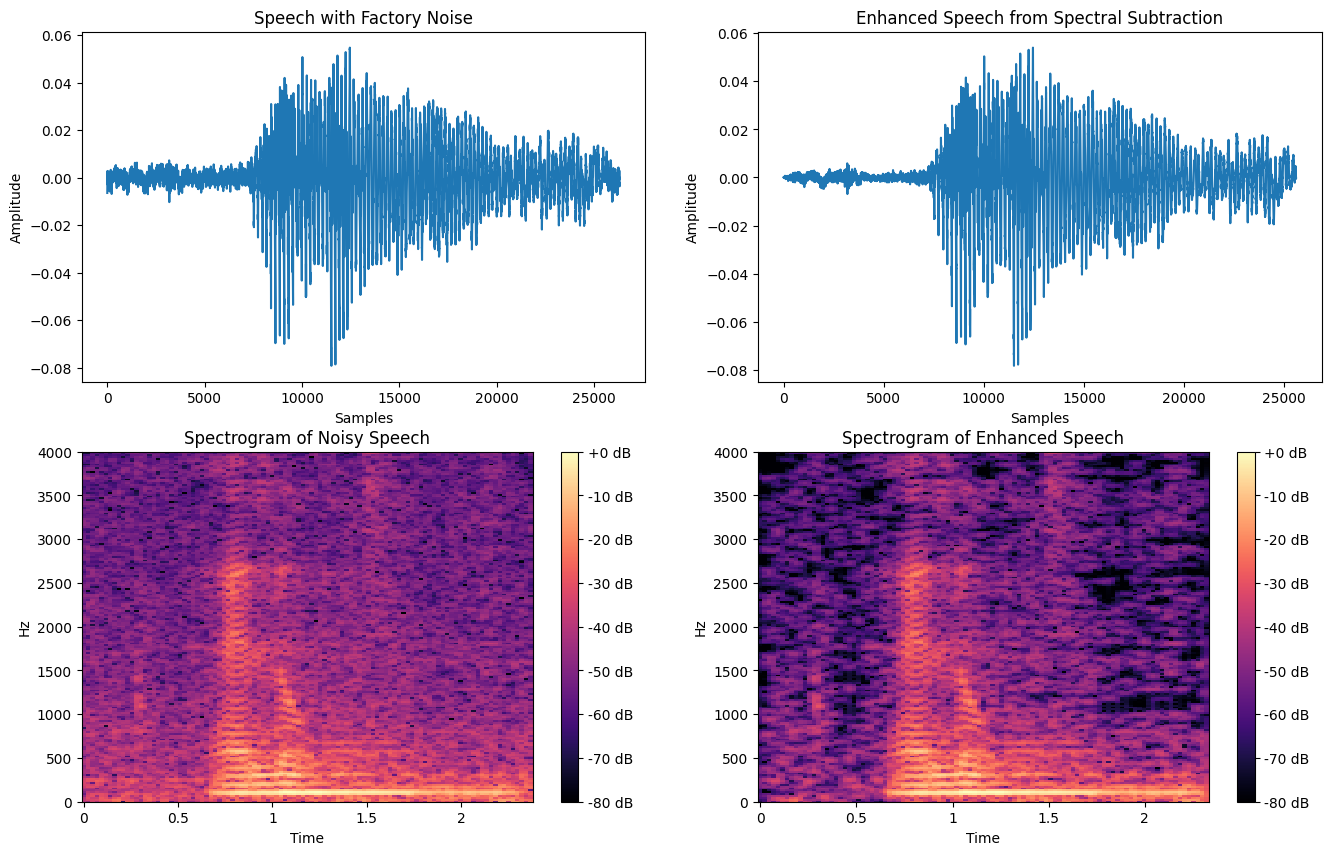

In [92]:
plt.figure(figsize=(16, 10))
plt.subplot(221)
plt.plot(x_factory)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Speech with Factory Noise")
plt.subplot(222)
plt.plot(y_factory_sub)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Enhanced Speech from Spectral Subtraction")
plt.subplot(223)
showSpectrogram(x_factory, 1024, 'Spectrogram of Noisy Speech')
plt.subplot(224)
showSpectrogram(y_factory_sub, 1024, 'Spectrogram of Enhanced Speech')
plt.savefig('sub_factory_comp_0.png', bbox_inches='tight')

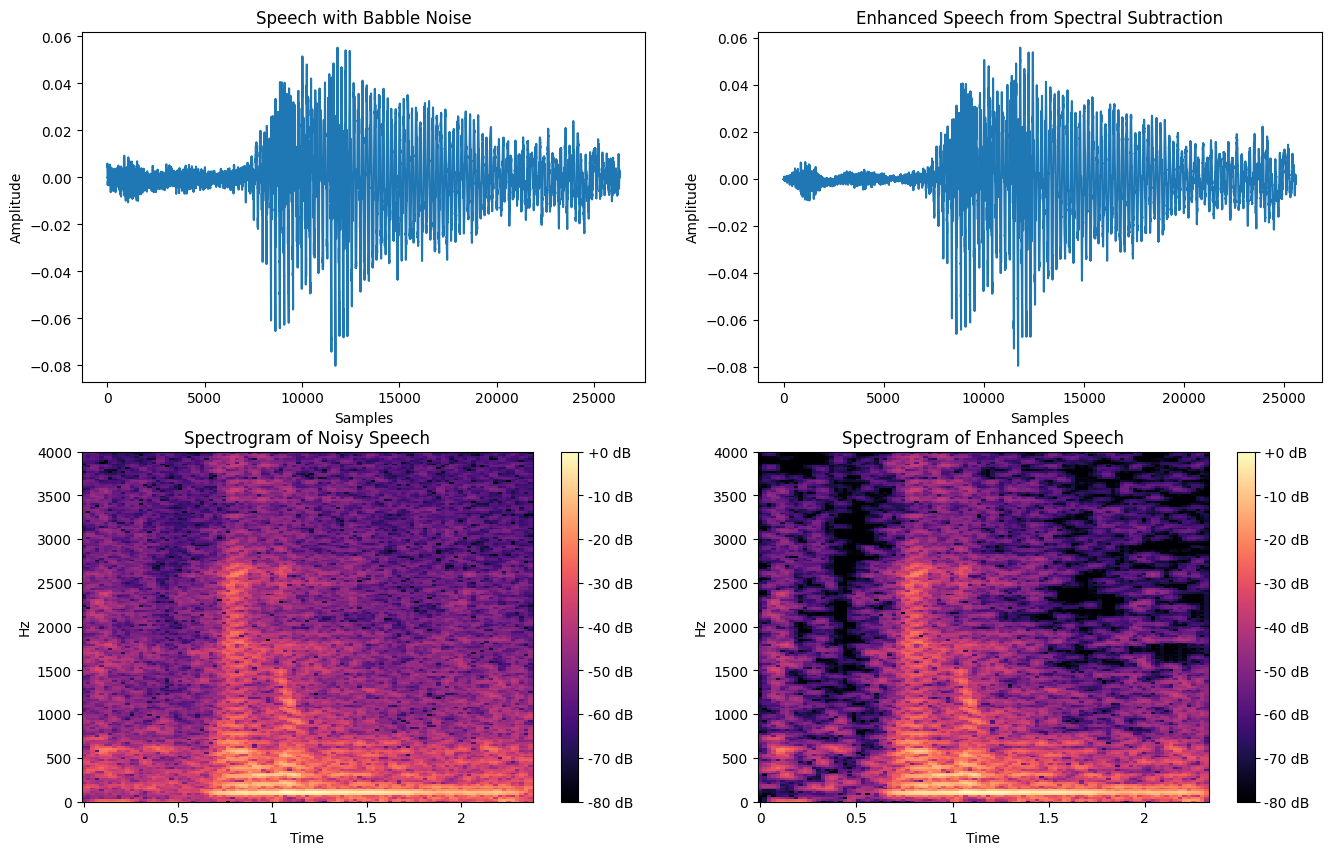

In [93]:
plt.figure(figsize=(16, 10))
plt.subplot(221)
plt.plot(x_babble)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Speech with Babble Noise")
plt.subplot(222)
plt.plot(y_babble_sub)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Enhanced Speech from Spectral Subtraction")
plt.subplot(223)
showSpectrogram(x_babble, 1024, 'Spectrogram of Noisy Speech')
plt.subplot(224)
showSpectrogram(y_babble_sub, 1024, 'Spectrogram of Enhanced Speech')
plt.savefig('sub_babble_comp_0.png', bbox_inches='tight')

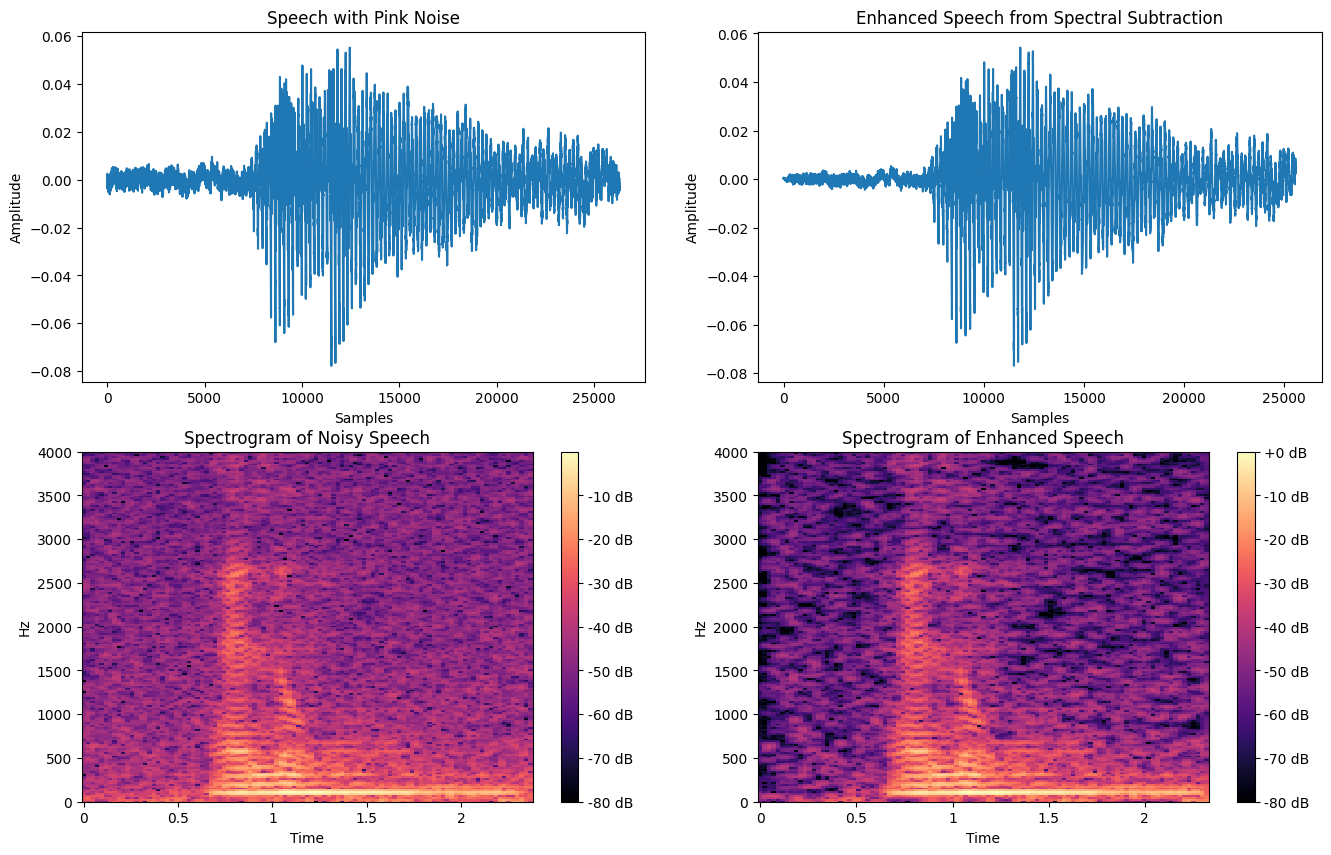

In [94]:
plt.figure(figsize=(16, 10))
plt.subplot(221)
plt.plot(x_pink)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Speech with Pink Noise")
plt.subplot(222)
plt.plot(y_pink_sub)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Enhanced Speech from Spectral Subtraction")
plt.subplot(223)
showSpectrogram(x_pink, 1024, 'Spectrogram of Noisy Speech')
plt.subplot(224)
showSpectrogram(y_pink_sub, 1024, 'Spectrogram of Enhanced Speech')
plt.savefig('sub_pink_comp_0.png', bbox_inches='tight')